In [454]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas_ta as ta
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Gather Stock Data from Yahoo Finance (open-source Python library)

In [456]:
nvidia = yf.Ticker("NVDA")
hist = nvidia.history(period="10y")
df = pd.DataFrame(hist)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-05 00:00:00-05:00,0.483144,0.484584,0.472823,0.474983,197952000,0.0,0.0
2015-01-06 00:00:00-05:00,0.475703,0.476183,0.460102,0.460582,197764000,0.0,0.0
2015-01-07 00:00:00-05:00,0.463943,0.468023,0.457942,0.459382,321808000,0.0,0.0
2015-01-08 00:00:00-05:00,0.464663,0.479543,0.464423,0.476663,283780000,0.0,0.0
2015-01-09 00:00:00-05:00,0.478343,0.482184,0.471863,0.478583,209540000,0.0,0.0


In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-05 00:00:00-05:00 to 2025-01-02 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2516 non-null   float64
 1   High          2516 non-null   float64
 2   Low           2516 non-null   float64
 3   Close         2516 non-null   float64
 4   Volume        2516 non-null   int64  
 5   Dividends     2516 non-null   float64
 6   Stock Splits  2516 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.2 KB


In [458]:
df = df.drop(columns=['Dividends', 'Stock Splits'])

In [459]:
df.describe()

,Open,High,Low,Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,20.846546,21.223335,20.431961,20.845017,4.676790e+08
std,32.435965,33.003243,31.759541,32.401901,2.535747e+08
min,0.463703,0.468023,0.454582,0.459382,5.244800e+07
25%,3.518327,3.597498,3.454667,3.552099,3.055120e+08
50%,6.453811,6.546365,6.350437,6.494542,4.151695e+08
75%,21.194650,21.793082,20.853817,21.261709,5.640210e+08
max,149.339720,152.879470,146.249911,148.869751,3.692928e+09


Visualise Data - Close Share Price

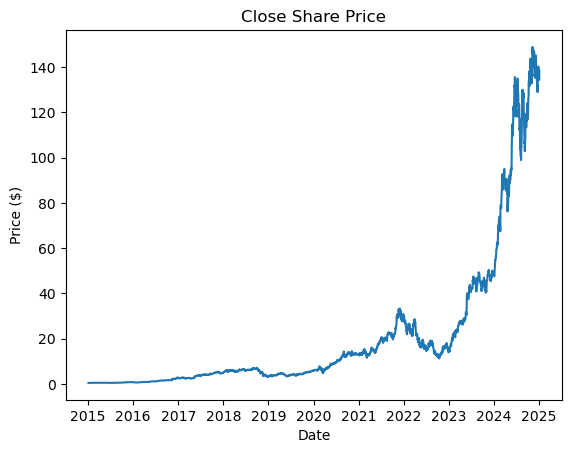

In [461]:
plt.plot(df.index, df["Close"]) # index - date
plt.title('Close Share Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

Add new variables:
- High_Low_diff - difference between the highest and lowest price during the day
- Open_Close_diff - difference between open and close price during the day
- Close_diff - price changes

In [463]:
df['High_Low_diff'] = df['High'] - df['Low']
df['Open_Close_diff'] = df['Open'] - df['Close']
df['Close_diff'] = df['Close'].diff().fillna(0)

Technical Stock Analysis
Add technical indicators:
- SMA_10 - simple moving average (10 days)
- EMA_20 - exponential moving average (20 days)
- EMA_50 - exponential moving average (50 days)
- Volatility_7 - price change without regard to direction
- RSI_14 - relative strength index

In [465]:
df['SMA_10'] = df['Close_diff'].rolling(window=10).mean()
df['EMA_10'] = df['Close_diff'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close_diff'].ewm(span=10, adjust=False).mean()
df['Volatility_7'] = df['Close'].rolling(window=7).std()
df['RSI_14'] = ta.rsi(df['Close_diff'], length=14)

<Figure size 640x480 with 0 Axes>

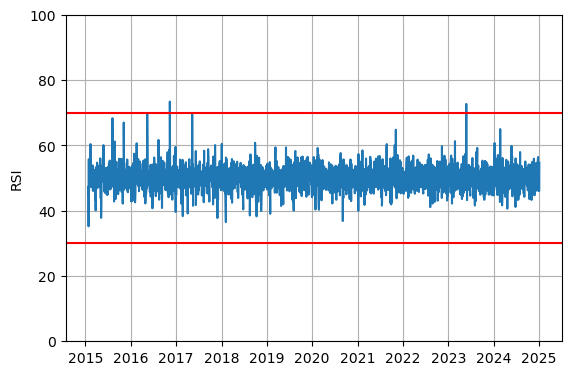

In [466]:
plt.figure()
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.plot(df.index, df['RSI_14'])
ax.set_ylim(0, 100)
ax.axhline(y=70, color='r', linestyle='-')
ax.axhline(y=30, color='r', linestyle='-')
ax.grid(True)
ax.set_ylabel(r'RSI')
plt.show()

Correlation Matrix

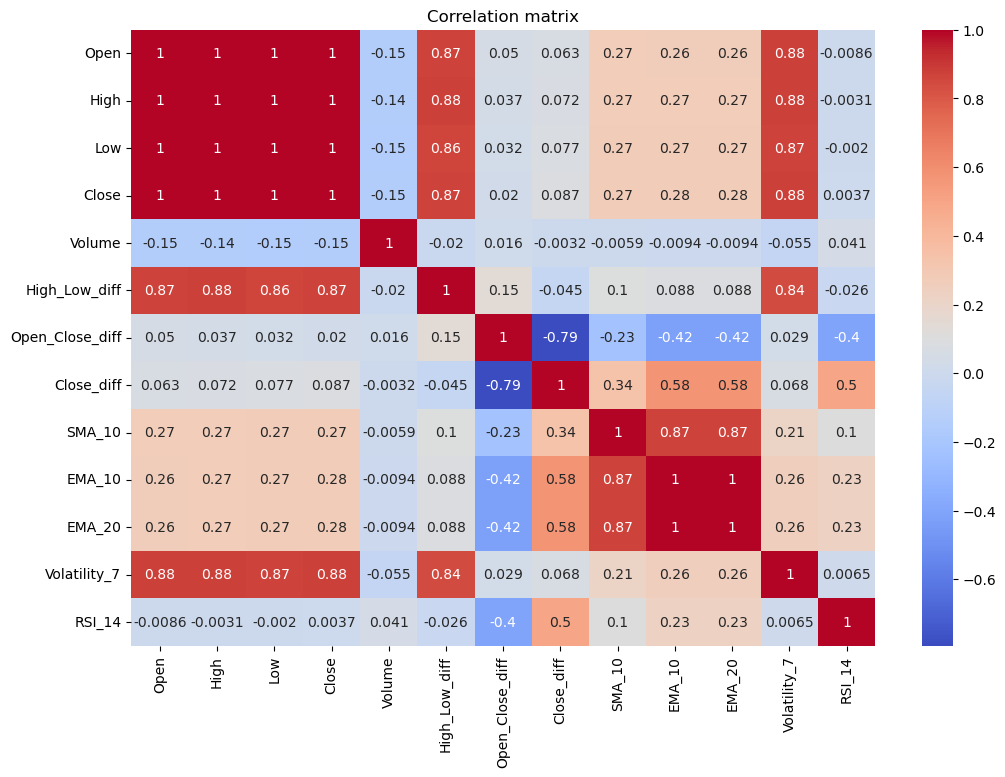

In [468]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Split data for training and testing

In [470]:
X = df.drop(columns=['Close', 'Close_diff'])
y = df['Close_diff']

split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

Standardize using StandardScaler

In [472]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Evaluate model function

In [474]:
def evaluate_model(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print('\nEvaluation:')
    print(f"MAE = {mae}")
    print(f"MSE = {mse}")
    print(f"R2 Score = {r2}")

Visualise predictions function

In [476]:
def visualise_predictions(y_test, predictions):
    plt.figure(figsize=(14, 6))
    plt.plot(y_test.index, y_test, label="True Price Difference", color='blue')
    plt.plot(y_test.index, predictions, label="Predicted Price Difference", color='red')
    plt.xlabel('Date')
    plt.ylabel('Price Difference')
    plt.legend()
    plt.show()

Model - RandomForestRegressor with check of the best parameters, note: not the best model for stock prices prediction ;)

In [478]:
model_rfr = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search_rfr = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search_rfr.fit(X_train_scaled, y_train)
predictions_rfr = grid_search_rfr.predict(X_test_scaled)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_e

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
828 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site

Best parameters for RandomForestRegressor: 
 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 



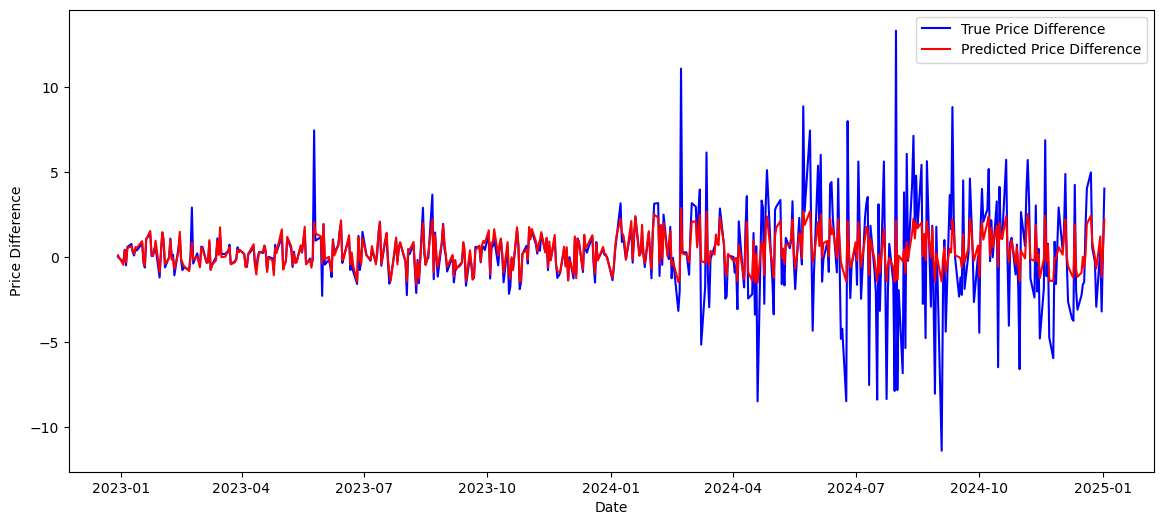


Evaluation:
MAE = 0.97791649805648
MSE = 3.3862669428902654
R2 Score = 0.49058695259889673


In [479]:
print("Best parameters for RandomForestRegressor: \n", grid_search_rfr.best_params_, "\n")

visualise_predictions(y_test, predictions_rfr)
evaluate_model(y_test, predictions_rfr)